# 대량 크롤링

## 라이브러리 임포트 및 함수 정의

In [16]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup
from newspaper import Article
import os




# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)   
    news = requests.get(url)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    #print(news_list)
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

def make_total_data(page_num, code_list, date):
    df = None

    for code in code_list:
        url_list = make_urllist(page_num, code, date) #BeautifulSoup select
        df_temp = make_data(url_list, code) #newspaer title conntent export
        print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

        if df is not None:
          df = pd.concat([df, df_temp]) # date 연결 이어 붙임 
        else:
          df = df_temp

    return df



## data 추출 후 csv 파일로 저장

In [17]:
# 아래 주석처리된 코드의 주석을 해제하고 실행을 하면 대량 크롤링이 진행됩니다. 
# 위에서 수행했던 크롤링의 100배 분량이 수행될 것입니다. 한꺼번에 너무 많은 크롤링 요청이 서버에 전달되지 않도록 주의해 주세요. 
# 기사 일자를 바꿔보면서 데이터를 모으면 더욱 다양한 데이터를 얻을 수 있게 됩니다. 

#df = make_total_data(100, code_list, 20200506)

# 

# # 데이터프레임 파일을 csv 파일로 저장합니다.
# # 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.

# csv_path = os.getenv("./news_data.csv")

# df.to_csv(csv_path, index=False)

# if os.path.exists(csv_path):
#   print('{} File Saved!'.format(csv_path))

- 파일 저장 받아놓음.. 현재경로 news_data.csv, news_data2.csv

## 데이터 정제

In [18]:
csv_path = "./news_data.csv" #파일 path
df = pd.read_table(csv_path, sep=',')  #파일 읽어드리기
df.head()

,news,code
0,파주시청. 사진제공=파주시 파주시청. 사진제공=파주시\n\n[파주=파이낸셜뉴스 강근...,사회
1,동영상 뉴스\n\n이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의...,사회
2,황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검. 사진...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회


In [19]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
# 개행 문자....
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

0       파주시청 사진제공파주시 파주시청 사진제공파주시파주파이낸셜뉴스 강근주 기자 파주시는 ...
1       동영상 뉴스이천 물류창고 화재 발화지점으로 지목된 지하 층에서 산소절단기의 산소 공...
2       황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검 사진제...
3       귀갓길 여성을 쫓아가 성범죄를 시도한 대 남성이 구속됐습니다서울 강남경찰서는 강간상...
4       서울연합뉴스 대한약사회가 일부터 코로나바이러스 감염증 대응 체계를 사회적 거리두기에...
                              ...                        
5119    신종 코로나바이러스 감염증코로나 사태 이후 가정의 달 월에도 언택트비대면 신풍속도가...
5120    는 소비자로부터 월 이용료 만만원을 받고 초고속 인터넷을 제공한다 그런 브로드밴드가...
5121    머리를 긁고 있는 오랑우탄 몸을 긁는 행동을 따라 하는 것은 부정적 감정과 관련이 ...
5122    가 오는 일 정식 출시하는 스마트폰 벨벳이 사실상 공짜폰이 될 전망이다 단말기 가격...
5123    이미지제공게티이미지뱅크 이미지제공게티이미지뱅크  전자신문  전자신문인터넷 무단전재 ...
Name: news, Length: 5124, dtype: object

In [20]:
# null 값 개수 조회
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [21]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  3994


## data 탐색

## 폰트 문제 

In [22]:
##폰트 문제 

# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm

# # 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
# #mpl.rcParams['axes.unicode_minus'] = False

# print ('버전: ', mpl.__version__)
# print ('설치 위치: ', mpl.__file__)
# print ('설정 위치: ', mpl.get_configdir())
# print ('캐시 위치: ', mpl.get_cachedir())

# print ('설정파일 위치: ', mpl.matplotlib_fname())

# font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# # ttf 폰트 전체갯수
# print(len(font_list)) 

# # size, family
# print('# 설정 되어있는 폰트 사이즈')
# print (plt.rcParams['font.size'] ) 
# print('# 설정 되어있는 폰트 글꼴')
# print (plt.rcParams['font.family'] )

# plt.rc('font', family='NanumGothic')

#fm.get_fontconfig_fonts()
#font_location = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'
# font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
#fprop = fm.FontProperties(fname=font_location)

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54876 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home

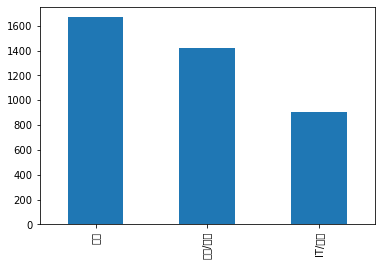

In [23]:

df['code'].value_counts().plot(kind = 'bar')

In [24]:
import matplotlib
matplotlib.__file__

'/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/__init__.py'

In [25]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학    903
1     사회   1668
2  생활/문화   1423


# 토큰화

In [26]:
import matplotlib
matplotlib.__file__

'/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/__init__.py'

# mecab

-  의미

- 설치 https://yuddomack.tistory.com/entry/%EC%B2%98%EC%9D%8C%EB%B6%80%ED%84%B0-%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94-EC2-konlpy-mecab-%EC%84%A4%EC%B9%98%ED%95%98%EA%B8%B0ubuntu

https://konlpy.org/en/latest/install/


https://sosomemo.tistory.com/30



In [27]:
from konlpy.tag import Mecab

tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']


## 불용어 제거

-  실제로 중요하지 않은 단어들 제거   
- ~가, ~은 ~는 , 조사 접사

In [28]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [29]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [30]:
text_data = preprocessing(df['news'])
print(text_data[0])

파주 시청 사진제 공파 주시 파주 시청 사진 제공 파주시 파주 강근주 파 주 시 일 관내 취약 계층 만 가구 대해 정부 긴급 재난 지원금 입금 완료 다파 주 시민 받 긴급 재난 지원금 인 이상 가구 기준 으로 만 원 받 게 되 며 인 가구 만 원 인 가구 만 원 인 가구 만 원 정부 발표 긴급 재난 지원금 파주 시민 지급 금액 다른 이유 국비 지방비 부담 비율 다파 주 시 이미 모든 시민 경기도 파주시 재난 기본 소득 인 당 각 만 원 지급 고 어 시민 국비 지원금 만 지급 며 인 가구 기준 으로 총 지원 금액 파주시 재난 기본소득 만 원 경기도 재난 기본소득 만 원 정부 긴급 재난 지원금 만 원 총 만 원 받 게 된다 취약 계층 아닌 시민 오 월일 부터 소지 고 신용 체크카드 사 홈페이지 에서 긴급 재난 지원금 지원 신청 세대주 가족 지원금 일괄 신청 해야 한다 한편 파 주 시 일 김정기 부시장 단장 으로 긴급 재난 지원금 추진 태 스 크 포스 를 구성 해 긴급 재난 지원금 원활 게 지급 될 도록 지원 한다 권 자 재 배포


#

- 나이브 베이즈 정리

In [31]:
# import library

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [32]:
# 훈련 데이터 테스트 데이터 정의

#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [33]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 2995
테스트용 뉴스 기사의 개수 :  999
훈련용 레이블의 개수 :  2995
테스트용 레이블의 개수 :  999


In [43]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
# 단어 데이터를 학습하고 문서 데이터를 document-form matrix로 변환하는 두 가지 작업을 해 줍니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#print(X_train_counts)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#print(X_train_tfidf)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)



MultinomialNB()


In [36]:
#텍스트를 입력하면 자동으로 TF-IDF 벡터로 바꾸는 전처리 함수
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [37]:
#
#

new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['사회']


In [38]:
##

new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [39]:
#test


new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['IT/과학']


In [40]:
# 모델을 예측하게하고, 실제값과 비교하여 점수를 측정

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.90      0.74      0.81       236
          사회       0.79      0.91      0.85       422
       생활/문화       0.81      0.76      0.79       341

    accuracy                           0.82       999
   macro avg       0.83      0.80      0.81       999
weighted avg       0.82      0.82      0.82       999

